In [16]:
import numpy as np
from astropy.convolution import convolve, Box2DKernel
from astropy.io import fits
import matplotlib.pyplot as plt

from skimage import filters, measure

def steles_read_file(fits_file):
    try:
        with fits.open(fits_file) as hdul:
            image_data   = hdul[0].data
            image_header = hdul[0].header
    except:
        raise ValueError("Check input fits file name and path.")
            
    channel = 'red' if image_header['FPA'] == "RED" else 'blue'   

    # make orders to increase from left to right
    if channel == 'red':
        image_data = np.flip(image_data,axis=1)
    
    return image_data, image_header, channel


def steles_save_file(data, header=None, file_out=None, quiet=True):
    
    if file_out is None:
        raise ValueError("Must provide a valid file_out value.")
    
    hdu = fits.PrimaryHDU(data=data, header=header)
    hdu.writeto(file_out, overwrite=True)
    
    if quiet is False:
        print('\tFITS file saved as {}'.format(file_out))
    #if header is None:
    #    hdu = fits.PrimaryHDU(data)
    #    hdu.writeto(file_out, overwrite=True)
    #    hdu.close()
    #else:
    #    fits.writeto(file_out, dta, header, overwrite=True)

def steles_mask_orders(image, box_size=15, gauss_filter=2, sigma_threshold=3):
    """
    Create a modified mask for a FITS image, excluding pixels below 3-sigma threshold and applying a moving median.

    Parameters
    ----------
    image : numpy.ndarray
        The 2D array representing the FITS image data.
    box_size : int
        The size of the box (odd number) used to calculate the median around each pixel.

    Returns
    -------
    mask : numpy.ndarray
        A 2D binary mask with the same shape as the input image.
        Pixels are set to 1 if they are above 3-sigma threshold and >= 50% of the median, else 0.
    """
    
    image = filters.gaussian(image, sigma=gauss_filter)
    
    # Step 1: Calculate the RMS (standard deviation) of the image, ignoring NaN values
    image_rms = np.nanstd(image)

    # Step 2: Create an initial mask where pixels are 1 if they are above the given sigma threshold, otherwise 0
    initial_mask = np.where(image >= sigma_threshold * image_rms, 1, 0)

    # Step 3: Apply the moving median only to the pixels above the 3-sigma threshold
    if box_size % 2 == 0:
        raise ValueError("Box size must be an odd number to have a defined center pixel.")

    # Use astropy's Box2DKernel to perform a convolution that acts like a median filter
    kernel = Box2DKernel(box_size)
    median_image = convolve(image, kernel, nan_treatment='interpolate', normalize_kernel=False)

    # Step 4: Create the final mask combining the 3-sigma threshold and median comparison
    final_mask = np.where((image >= 0.5 * median_image) & (initial_mask == 1), 1, 0)

    return final_mask


#######################################################################################
print('functions were loaded.')

functions were loaded.


In [17]:
## Load fits files

# Load your FITS file and extract the data
infolder = 'D:/SOAR/Steles/2023-04-18_data_reduction_red/'

quartz_file = 'dataset_0003_q.fits' # Quartz lamp
arc_file = 'dataset_0017_q.fits'    # ThAr lamp 1 sec
sun_file = 'dataset_0014_q.fits'    # Solar spectrum 120 sec

# read fits files
quartz_data, quartz_header, quartz_channel = steles_read_file(infolder + quartz_file)
arc_data,    arc_header,    arc_channel    = steles_read_file(infolder + arc_file)
sun_data,    sun_header,    sun_channel    = steles_read_file(infolder + sun_file)

#image_data = image_data0[1500:2500,980:1980]
print('Files were loaded.')

Files were loaded.


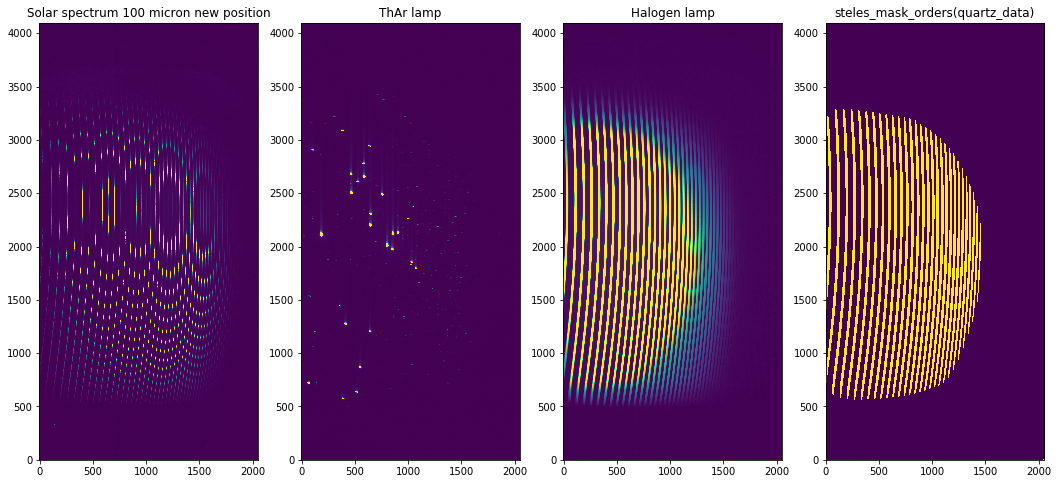

	FITS file saved as D:/SOAR/Steles/2023-04-18_data_reduction_red/mask_orders.fits


In [18]:
# run steles_mask_orders() and plot the data

# Create the mask using the defined function
mask_orders = steles_mask_orders(quartz_data, box_size=15, sigma_threshold=0.25)
print("steles_mask_orders() is not currently being used. so it can be skipped.")

# show the results
plt.figure(figsize=(18,18))
plt.subplot(141)
plt.imshow(sun_data, vmin=0, vmax=1000, origin='bottom')
plt.title(sun_header['OBJECT'])
plt.subplot(142)
plt.imshow(arc_data, vmin=0, vmax=1000, origin='bottom')
plt.title(arc_header['OBJECT'])
plt.subplot(143)
plt.imshow(quartz_data, vmin=0, vmax=1000, origin='bottom')
plt.title(quartz_header['OBJECT'])
plt.subplot(144)
plt.imshow(mask_orders, origin='bottom')
plt.title('steles_mask_orders(quartz_data)')
plt.show()

# Optional: Save the mask to a new FITS file
steles_save_file(mask_orders, header=None, file_out=infolder + 'mask_orders.fits', quiet=False)

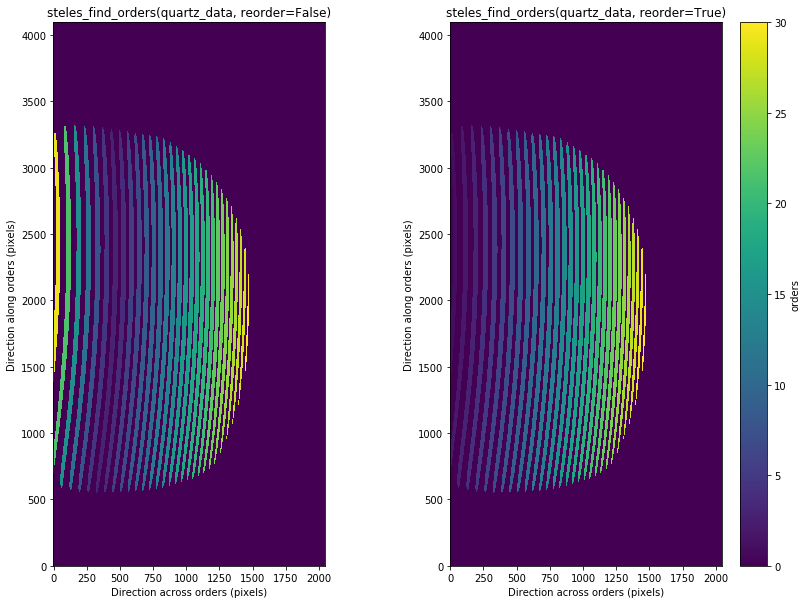

	FITS file saved as D:/SOAR/Steles/2023-04-18_data_reduction_red/orders.fits


In [39]:


def steles_arrange_orders(orders, channel):
    
    
    # set the row to use for each channel (direction across orders)
    yref= 2000 if channel=='red' else 1000

    # get the order numbers larger than 0 (background) at the reference yref position
    number_orders=orders[yref,:]
    n_orders = number_orders[number_orders > 0]

    # now get the number of orders as a function of the x-axis (from left to right)
    uniq_vals = None
    for v in n_orders:
        if uniq_vals is None:
            uniq_vals = []
            uniq_vals.append(v)
        if v not in uniq_vals:
            uniq_vals.append(v)
    
    # start an array ranging from 1 to the maximum order number of the original data
    new_n_orders = np.arange(len(uniq_vals))+1
    
    # now create a new mask to replace the old values
    new_orders = orders.copy()
    
    # now reorder the spectral orders from left to right
    for i,n in enumerate(uniq_vals):
        mask = (orders == n)
        new_orders[mask] = new_n_orders[i]
        
    return new_n_orders, new_orders
    

def steles_find_orders(image, gauss_filter=2, percentile_cut=76, minpix=100, reorder=False, channel=None):

    # use a low-order Gaussian fit to smooth the noise
    image = filters.gaussian(image, sigma=gauss_filter)
    
    # Step 2: Create an initial mask for pixels above a given percentile threshold
    # WARNING: individual orders must not overlap otherwise they will be treated as a single order
    mask = image > np.percentile(image, percentile_cut)

    # 'count' the orders
    img_orders = measure.label(mask)
    
    # identify each order
    n_orders = np.unique(img_orders)
        
    # remove results from measure.label() that are not associated with orders (could be a batch of bright spots)
    # an individual order must have a minimum number of connected pixels given by 'minpix'.
    for n in list(n_orders):
        mask = ( img_orders == n )
        if len(img_orders[mask]) < minpix:
            img_orders[mask] = 0.0
            
    # reidentify each order
    n_orders = np.unique(img_orders)
    
    # arrange orders, making their number ascending from left to right
    if reorder:
        if channel is None:
            raise ValueError("Must provide 'channel' information for arranging the orders in crescent mode.")
        n_orders, img_orders= steles_arrange_orders(img_orders, channel)
    
    return n_orders, img_orders

# get the order number
n_orders0, orders0 = steles_find_orders(quartz_data, gauss_filter=4, percentile_cut=76, minpix=1000, channel=quartz_channel, reorder=False)
n_orders,  orders  = steles_find_orders(quartz_data, gauss_filter=4, percentile_cut=76, minpix=1000, channel=quartz_channel, reorder=True)


plt.figure(figsize=(14,10))

plt.subplot(121)
plt.imshow(orders0, vmin=0, vmax=max(n_orders0), origin='bottom')
plt.title('steles_find_orders(quartz_data, reorder=False)')
plt.xlabel('Direction across orders (pixels)')
plt.ylabel('Direction along orders (pixels)')

plt.subplot(122)
plt.imshow(orders, vmin=0, vmax=max(n_orders), origin='bottom')
plt.colorbar(label='orders')
plt.title('steles_find_orders(quartz_data, reorder=True)')
plt.xlabel('Direction across orders (pixels)')
plt.ylabel('Direction along orders (pixels)')
plt.show()

# Optional: Save the mask to a new FITS file
steles_save_file(orders, header=None, file_out=infolder + 'orders.fits', quiet=False)

Tracing the spectral orders
1 50.27561059991594
2 0.2162817656053361
3 0.06319958911579537
4 0.04557115392217983
1 556.8998374272389
2 1.121027793215888
3 0.7838091230439111
4 0.219374348118182
1 528.9192025654105
2 0.13293719291116
3 0.10527699837885672
4 0.05056534507234948
1 441.4930401669243
2 0.039325321508009395
3 0.03908406279971349
4 0.03906625014168116
1 3.6864811217123226
2 0.044226936874803106
3 0.04290035122913754
4 0.04282366179846839


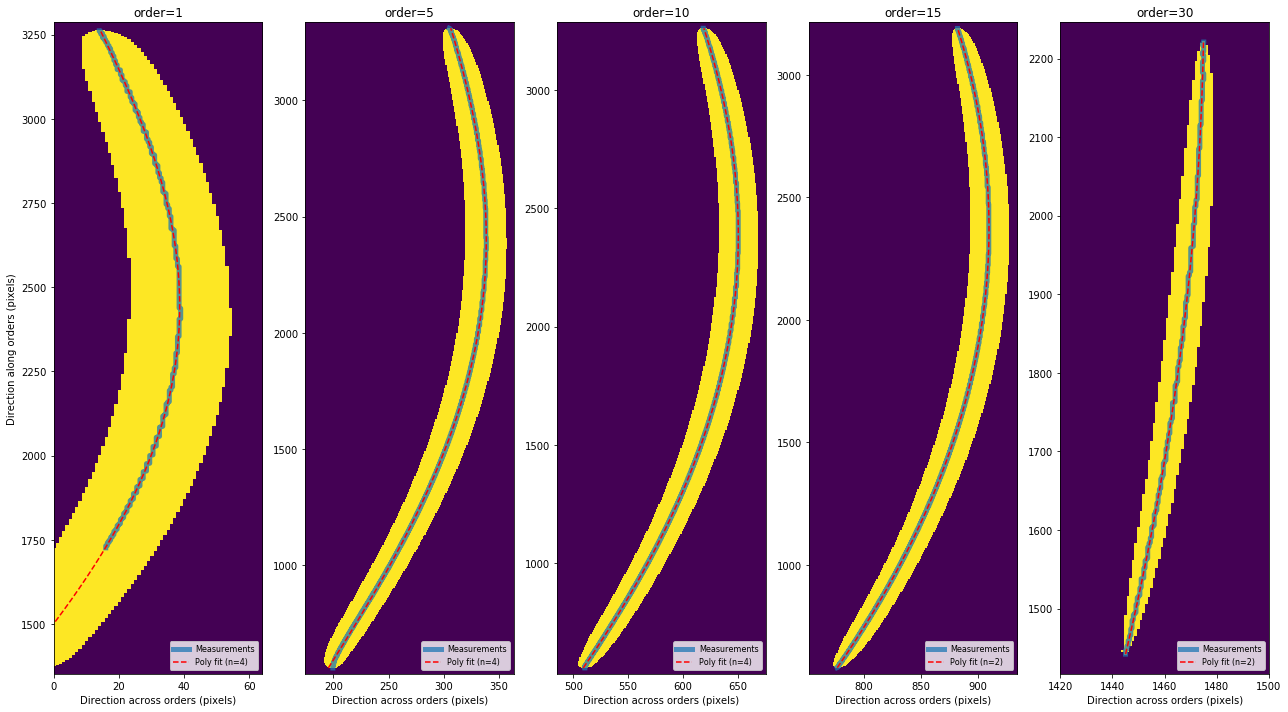

	order=01	spec_xlow=1377	spec_xhigh=3261	fit_order=4
	order=02	spec_xlow=683	spec_xhigh=3315	fit_order=4
	order=03	spec_xlow=591	spec_xhigh=3320	fit_order=4
	order=04	spec_xlow=568	spec_xhigh=3315	fit_order=4
	order=05	spec_xlow=558	spec_xhigh=3311	fit_order=4
	order=06	spec_xlow=553	spec_xhigh=3301	fit_order=4
	order=07	spec_xlow=552	spec_xhigh=3291	fit_order=4
	order=08	spec_xlow=552	spec_xhigh=3281	fit_order=4
	order=09	spec_xlow=553	spec_xhigh=3271	fit_order=4
	order=10	spec_xlow=556	spec_xhigh=3262	fit_order=4
	order=11	spec_xlow=559	spec_xhigh=3253	fit_order=4
	order=12	spec_xlow=562	spec_xhigh=3246	fit_order=4
	order=13	spec_xlow=566	spec_xhigh=3240	fit_order=4
	order=14	spec_xlow=572	spec_xhigh=3219	fit_order=2
	order=15	spec_xlow=581	spec_xhigh=3189	fit_order=2
	order=16	spec_xlow=589	spec_xhigh=3162	fit_order=2
	order=17	spec_xlow=601	spec_xhigh=3132	fit_order=2
	order=18	spec_xlow=611	spec_xhigh=3101	fit_order=3
	order=19	spec_xlow=628	spec_xhigh=3070	fit_order=4
	order=20	s

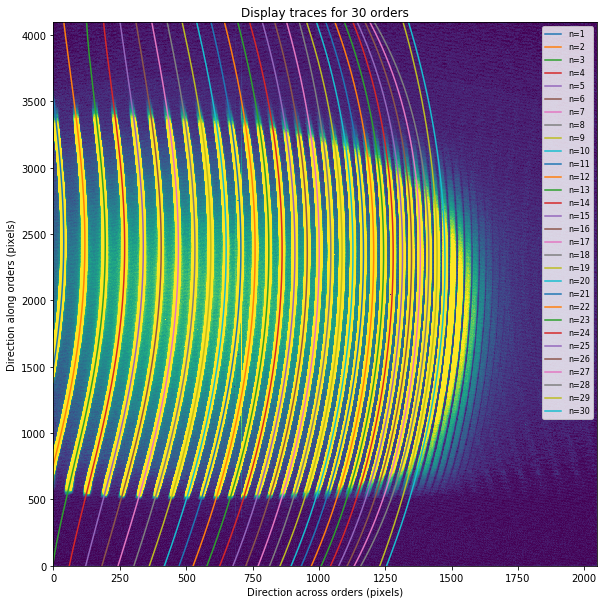

In [193]:
def polynomialfit(x, y, nmin=1, nmax=3, debug=False):
    """
    Select the minimum chi squared polynomial fit between nmin and nmax

    :param x: x axis array
    :param y: y axis array
    :param nmin: minimum order to fit
    :param nmax: maximum order to fit

    Note could improve this to weight it by pixel uncertainties
    """
    chis, ps = [], []
    nrange = range(nmin, nmax+1)
    
    for n in nrange:
        p = np.polyfit(x, y, n)
        yfit = np.polyval(p, x)
        
        # get the reduced chi2
        chi_squared = np.sum((y-yfit)**2)
        
        ps.append(p)
        chis.append(chi_squared)
        #if debug:
        #    print(n,chi_squared)
    
    argmin = np.argmin(chis)
    return ps[argmin], nrange[argmin]

def eval_polynomialfit(x, y, nmin=1, nmax=3, chi2_threshold=0.1, debug=False):
    """
    Select the minimum chi squared polynomial fit between nmin and nmax

    :param x: x axis array
    :param y: y axis array
    :param nmin: minimum order to fit
    :param nmax: maximum order to fit

    Note could improve this to weight it by pixel uncertainties
    """
    chis, ps = [], []
    nrange = range(nmin, nmax+1)
    
    for n in nrange:
        p = np.polyfit(x, y, n)
        yfit = np.polyval(p, x)
        
        # evaluate the degrees of freedom of the plot
        dof = len(x) - n - 1
        # get the reduced chi2
        chi_squared = np.sum((y-yfit)**2) / dof
        
        ps.append(p)
        chis.append(chi_squared)
        if debug:
            print(n,chi_squared)
    #print(chis)
    
    best_degree = None
    best_chi2 = np.inf
    for i,n in enumerate(nrange):
        # Check for the simplest model within the threshold
        
        #if best_degree is not None:
        #    print(i,chis[i], best_chi2, chis[i] < best_chi2, best_chi2 - chis[i], best_chi2 - chis[i] < chi2_threshold)
        
        if chis[i] < best_chi2:
            if best_degree is not None and best_chi2 - chis[i] < chi2_threshold:
                #best_degree = min(best_degree, n)  # Choose simpler model
                best_degree = min(best_degree, i)  # Choose simpler model
            else:
                #best_degree = n
                best_degree = i
                best_chi2 = chis[i]
        #print(i,best_degree)
        
    argmin = best_degree #np.where(nrange == best_degree)[0]
    #print('best_degree=',nrange[argmin])
    return ps[argmin], nrange[argmin]

def steles_trace_orders(n_orders, orders, fmin=1, fmax=3, debug=False, n_debug =[1]):
    
    pfits, forders, xls, xhs = [], [], [], []

    n_plot=1
    # loop around each order (blob regions)
    for n in n_orders:
        # ignore the 0 region (background region)
        if n == 0:
            continue
        # create a mask for this region
        mask = ( orders == n )
          
        # Extract x and y positions of this mask
        # x - along the order (spectral)
        # y - across the orders (spatial)
        px, py = np.where(mask)
        # get limits for spectral direction
        px_min = np.nanmin(px)
        px_max = np.nanmax(px)

        # save the min and max fit points
        xls.append(px_min)
        xhs.append(px_max)

        # create an array for spectral pixels
        xvals = np.arange(px_min,px_max+1)
        # I want the corresponding array of spatial pixels, I will use the mean values.
        yvals = []
        for x in xvals:
            # first, remove zero values
            y_nonzero = np.where(mask[x,:] > 0)
            # now, get the average value of the spatial dimension
            yval = np.nanmean(y_nonzero)
            # if the order is at the border of the detector, exclude the region that is cutted out
            if ( np.min(y_nonzero) == 0 ) or ( np.max(y_nonzero) == mask[x,:].shape[0]-1) :
                yval = np.nan
            yvals.append(yval)

        # get limits for spatial direction
        py_min=np.nanmin(yvals)
        py_max=np.nanmax(yvals)

        yvals = np.array(yvals)
        # remove nan values before fitting
        idx_fit = np.isfinite(yvals)


        # fit a polynomial to this order
        #pfs, ns = polynomialfit(xvals[idx_fit], yvals[idx_fit], nmin=fmin, nmax=fmax, debug=(debug and n in n_debug))
        # fit a polynomial to this order using a threshold on the reduced chi2 value to avoid overfitting
        pfs, ns = eval_polynomialfit(xvals[idx_fit], yvals[idx_fit], nmin=fmin, nmax=fmax, chi2_threshold=0.01, debug=(debug and n in n_debug))
        # evaluate the polynomial fit
        y_fit = np.polyval(pfs,xvals)
        # save the coefficients and order of the polynomial fit
        pfits.append(pfs)
        forders.append(ns)
        
        # print results for a specific order 'n_debug'
        if debug:
            if n_plot == 1:
                plt.figure(figsize=(18,10))
                
            if n in n_debug:
                plt.subplot(1,len(n_debug),n_plot)
                plt.imshow(mask, origin='bottom', aspect='auto')
                plt.plot(yvals,xvals, lw=5, alpha=0.75, label='Measurements')
                plt.plot(y_fit,xvals, ls='--', color='red', label='Poly fit (n={})'.format(forders[n-1]))
                pix_limit = 25
                plt.xlim(py_min-pix_limit if py_min > pix_limit else 0,py_max+pix_limit if py_max < mask[x,:].shape[0]-pix_limit-1 else mask[x,:].shape[0]-1)
                plt.ylim(px_min-pix_limit,px_max+pix_limit)
                plt.xlabel('Direction across orders (pixels)')
                if n_plot == 1:
                    plt.ylabel('Direction along orders (pixels)')
                plt.title('order={}'.format(n))
                plt.legend(loc='lower right',fontsize=8)
                n_plot += 1
    plt.tight_layout()
    plt.show()
             
    return pfits, forders, xls, xhs

def plot_trace(quartz_data, polyfits):

    xarr0 = range(0, quartz_data.shape[0])
    plt.figure(figsize=(10,10))
    plt.imshow(quartz_data, aspect=0.5,vmin=0,vmax=100)
    for i,polyfit in enumerate(polyfits):
        yval=np.polyval(polyfit, xarr0)
        #ymaxs.append(np.max(np.polyval(polyfit, xarr0)))

        plt.plot(yval,xarr0,label='n={}'.format(i+1))
    plt.legend(fontsize=8)
    plt.xlim(0,quartz_data.shape[1])
    plt.ylim(0,quartz_data.shape[0])
    plt.xlabel('Direction across orders (pixels)')
    plt.ylabel('Direction along orders (pixels)')
    plt.title('Display traces for {} orders'.format(i+1))
    plt.show()


print('Tracing the spectral orders')
polyfits, fitorders, xlows, xhighs = steles_trace_orders(n_orders, orders, fmin=1, fmax=4, debug=True, n_debug=[1,5,10,15,30])

for i,r in enumerate(n_orders):
    print('\torder={:02d}\tspec_xlow={}\tspec_xhigh={}\tfit_order={}'.format(r,xlows[i],xhighs[i],fitorders[i]))

plot_trace(quartz_data, polyfits)

30

In [245]:

import matplotlib.cm as cmaps
from astropy.table import Table
from tqdm import tqdm
# =============================================================================
# Define plotting functions
# =============================================================================
def plot_image(image, percentile_display=[5,95], name=None, spath=None, show=False):
    """
    Plots the raw CCD image to $spath$/$n$_Original[.png,.pdf]

    :param image: numpy 2D array, containing the CCD image

    :param n: string, name of the CCD image (extracted from file name) forms
              prefix of plot filename

    :param spath: path to save the plot to

    :param show: if True then plot is shown instead of saved

    :return:
    """
    
    displ_range = np.percentile(image, percentile_display)
    
    fig, frame = plt.subplots(1, 1)
    fig.set_size_inches(10, 10)
    frame.imshow(image, cmap='viridis', vmin=displ_range[0], vmax=displ_range[1])
    frame.set_xticklabels([])
    frame.set_yticklabels([])
    frame.xaxis.set_ticks_position('none')
    frame.yaxis.set_ticks_position('none')
    
    if name is not None:
        sname = spath + name + '_Original'
        plt.savefig(sname + '.png', bbox_inches='tight')
    
    plt.show()
    if name is not None:
        print('plot saved as {}'.format(sname))
        plt.close()
        

def plot_found_orders(dblobs, name=None, spath=None, show=False):
    """
    Plots the found orders over the raw CCD image to
    $spath$/$n$_FoundOrders[.png,.pdf]

    :param dblobs: numpy 2D array equal in shape to the input image, contains
                    located "blobs" which should be the orders (if they were
                    detectable) format is 0 where no order is found and then
                    a different integer for each "blob" found

                    i.e.:

                        010203
                        010203
                        010203
                        010203

                        identifies three orders

    :param n: string, name of the CCD image (extracted from file name) forms
              prefix of plot filename

    :param spath: path to save the plot to

    :param show: if True then plot is shown instead of saved

    :return:
    """
    fig, frame = plt.subplots(1, 1)
    fig.set_size_inches(10, 10)
    frame.patch.set_facecolor('black')
    # frame.imshow(image, cmap='gray')
    # ddd = np.ma.masked_where(dblobs == 0, dblobs)
    uorders = np.unique(dblobs)
    ublobs = np.array(dblobs)
    for it in range(len(uorders)):
        oit = uorders[it]
        if oit == 0:
            continue
        mask = ublobs == oit
        if np.sum(mask) == 0:
            continue
        ublobs[mask] = it

    cmap = cmaps.jet
    cmap.set_bad('black', 0.0)
    frame.imshow(ublobs, cmap='jet')
    frame.set_xticklabels([])
    frame.set_yticklabels([])
    frame.xaxis.set_ticks_position('none')
    frame.yaxis.set_ticks_position('none')

    if name is not None:
        sname = str(spath) + name + '_FoundOrders'
        plt.savefig(sname + '.png', bbox_inches='tight')
    
    plt.show()
    if name is not None:
        print('plot saved as {}'.format(sname))
        plt.close()


def plot_fitted_orders(image, pfits, xls, xhs, percentile_display=[5,95], name=None, spath=None, show=False,
                       return_frame=True, frame=None, mask=None):
    """
    Plots the fitted orders over the raw CCD image to
    $spath$/$n$_FittedOrders[.png,.pdf]

    :param image: numpy 2D array, containing the CCD image

    :param pfits: list, length same as number of orders, polynomial values
                      (output of np.polyval)

                      i.e. p where:

                      p[0]*x**(N-1) + p[1]*x**(N-2) + ... + p[N-2]*x + p[N-1]

    :param xls: list, length same as number of orders, the lowest x pixel
                   (wavelength direction) used in each order

    :param xhs: list, length same as number of orders, the highest x pixel
                   (wavelength direction) used in each order

    :param n: string, name of the CCD image (extracted from file name) forms
              prefix of plot filename

    :param spath: path to save the plot to


    :param show: if True then plot is shown instead of saved

    :return:
    """
    
    displ_range = np.percentile(image, percentile_display)
    
    if mask is None:
        print('mask none')
        mask = np.repeat([True], len(pfits))
        
    fig, frame = plt.subplots(1, 1)
    fig.set_size_inches(10, 10)
    frame.imshow(image, cmap='viridis', vmin=displ_range[0], vmax=displ_range[1])

    names = np.arange(1, len(pfits)+1)
    # Loop around each order and plot fits
    for pp, pf in enumerate(pfits):
        if mask[pp] == False:
            continue
        else:
            xarr = np.arange(xls[pp], xhs[pp], 1)
            yarr = np.polyval(pf, xarr)
            yarr[yarr < 0] = 0
            yarr[yarr > len(yarr)] = len(yarr)

            ymid = np.median(yarr)
            xmid = np.median(xarr)

            frame.plot(yarr, xarr, color='r', linewidth=2)
            frame.text(ymid, xmid, 'Order{0}'.format(names[pp]),
                       horizontalalignment='center', verticalalignment='center',
                       rotation=90, color='g', zorder=5)

    # finalise graph
    frame.set_xlim([0, len(image[0])])
    frame.set_ylim([0, len(image)])
    frame.set_xticklabels([])
    frame.set_yticklabels([])

    if name is not None:
        sname = str(spath) + name + '_FittedOrders'
        plt.savefig(sname + '.png', bbox_inches='tight')
    
    plt.show()
    if name is not None:
        print('plot saved as {}'.format(sname))
        plt.close()      
        

def save_fits(pfits, xls, xhs, fitmax=4, name=None, spath=None):
    """
    save the fits to file, for use in extracting future spectra

    :param pfits: list, length same as number of orders, polynomial values
                      (output of np.polyval)

                      i.e. p where:

                      p[0]*x**(N-1) + p[1]*x**(N-2) + ... + p[N-2]*x + p[N-1]

    """
    data = []
    cols = ['Order'] + list(range(fitmax + 1))[::-1]
    cols += ['low_x', 'high_x']

    # Loop around each order and plot fits
    for pp, pf in enumerate(pfits):
        row = [pp + 1] + list(np.zeros(fitmax + 1 - len(pf)))
        row += list(pf)
        row += [xls[pp], xhs[pp]]
        data.append(row)
    data = np.array(data)

    # convert to astropy table
    atable = Table()
    for c, col in enumerate(cols):
        atable[str(col)] = data[:, c]

    if name is not None:
        sname = spath + name + '_poly_fits.fits'
        atable.write(sname, overwrite=True)


def extract_orders(image, pfits, xls, xhs, width, name, spath, median=False, quiet=True):
    """
    Extract the spectra from each of the orders and return in a list of numpy
    arrays

    :param image: numpy 2D array, containing the CCD image

    :param pfits: list, length same as number of orders, polynomial values
                      (output of np.polyval)

                      i.e. p where:

                      p[0]*x**(N-1) + p[1]*x**(N-2) + ... + p[N-2]*x + p[N-1]
    :param xls: list, length same as number of orders, the lowest x pixel
                   (wavelength direction) used in each order

    :param xhs: list, length same as number of orders, the highest x pixel
                   (wavelength direction) used in each order

    :param w: int, number of pixels either side of the polynomial to sum
              (extract) to create the spectrum pixels

    :return spec: list,  length same as number of orders, each containing
                  a 1D numpy array with the spectrum of each order in

    """
    spec = []
    xarr = range(0, len(image))
    # FN - datacube
    multi_spec2d = np.ndarray((len(pfits),2*width+1,len(image)))
    multi_spec   = np.ndarray((len(pfits),len(image)))
    
    # loop through orders
    for pp, pf in enumerate(pfits):
        
        if quiet is False:
            print('\t\t Order {0}'.format(pp + 1))
        
        # FN - datacube
        #spec2d = np.ndarray((2*width+1,len(image)))
        
        # find nearest y pixel (spectral pixel)
        xarr1 = range(xls[pp], xhs[pp])
        
        # get correspondig spatial pixels
        yarr = np.array(np.round(np.polyval(pf, xarr), 0), dtype=int)

        yarr[yarr < 0] = 0.0
        yarr[yarr > len(image[0])-1] = len(image[0])-1
        
        #print(pp, min(yarr),max(yarr))
        
        # loop around x pixels (spectral direction)
        ospec = []
        for xrow in xarr:
        #for xrow in tqdm(xarr):
            # find the lower bound for extraction of y 
            # (i.e. need to deal with going out of bounds )
            if yarr[xrow] - width < 0:
                lower = 0
            else:
                lower = yarr[xrow] - width
            # find the upper bound for extraction of y
            if yarr[xrow] + width > len(image[0]):
                upper = len(image[0])
            else:
                upper = yarr[xrow] + width
            
            # extract and sum pixels to form this x pixel (wavelength) count
            if xrow in xarr1:
                ssum = np.sum(image[xrow, lower: upper]) if median is False else np.median(image[xrow, lower: upper])
                ospec.append(ssum)
                
                #if xrow == min(xarr1):
                #    print(pp, image[xrow, lower: upper].shape)
                    
                #FN
                if image[xrow, lower: upper].shape[0] > 0:
                    #spec2d[:upper-lower, xrow] = image[xrow, lower: upper]
                    
                    #if pp ==1:
                    #    print(pp, image[xrow, lower: upper].shape)
                    #spec2d[2*width+1-(upper-lower):, xrow] = image[xrow, lower: upper]
                    multi_spec2d[pp,2*width+1-(upper-lower):, xrow] = image[xrow, lower: upper]
            else:
                ospec.append(np.NaN)
            
        spec.append(ospec)
        multi_spec[pp,:] = ospec

        # save fits file
        #sname = spath + name + '_spec2d_{}.fits'.format(pp+1)
        #hdu = fits.PrimaryHDU(spec2d)
        #hdu.writeto(sname, overwrite=True)
        
    # save fits file
    sname = spath + name + '_spec.fits'
    hdu = fits.PrimaryHDU(multi_spec)
    hdu.writeto(sname, overwrite=True)
    
    sname2d = spath + name + '_spec2d.fits'
    hdu2d = fits.PrimaryHDU(multi_spec2d)
    hdu2d.writeto(sname2d, overwrite=True)

    return spec

def save_orders(spec, name, spath):
    """
    Save each order to file
    :param spec: list,  length same as number of orders, each containing
                  a 1D numpy array with the spectrum of each order in
    :param spath: path to save the fits file to
                  (columns = pixel number and counts)
    """
    
    
    for s in range(len(spec)):
        nt = Table()
        nt['pixel number'] = np.arange(0, len(spec[s]))
        nt['counts'] = spec[s]
        sname = spath + name + '_order_{0}.fits'.format(s+1)
        nt.write(sname, overwrite=True)

def plot_orders(pfits, spec, name, spath):
    """
    Plots the extracted order spectra counts vs pixel location
    $spath$/$n$_Spectrum_order_{0}[.png,.pdf]

    :param pfits: list, length same as number of orders, polynomial values
                      (output of np.polyval)

                      i.e. p where:

                      p[0]*x**(N-1) + p[1]*x**(N-2) + ... + p[N-2]*x + p[N-1]

    :param spec: list,  length same as number of orders, each containing
                  a 1D numpy array with the spectrum of each order in

    :param n: string, name of the CCD image (extracted from file name) forms
              prefix of plot filename

    :param spath: path to save the plot to

    :return:
    """
    for pp, pf in enumerate(pfits):
        fig, frame = plt.subplots(1, 1)
        fig.set_size_inches(10, 10)
        frame.plot(spec[pp])
        frame.set_xlabel('Pixel value')
        frame.set_ylabel('Counts')
        frame.set_title('Order no. {0}'.format(pp + 1))
        sname = spath + name + '_spectrum_order_{0}'.format(pp + 1)
        plt.savefig(sname + '.png', bbox_inches='tight')
        # plt.savefig(sname + '.pdf', bbox_inches='tight')
        plt.close()
        
        
def plot_orders_single(pfits, spec, name, spath):
    """
    Plots the extracted order spectra counts vs pixel location
    $spath$/$n$_Spectrum_order_{0}[.png,.pdf]

    :param pfits: list, length same as number of orders, polynomial values
                      (output of np.polyval)

                      i.e. p where:

                      p[0]*x**(N-1) + p[1]*x**(N-2) + ... + p[N-2]*x + p[N-1]

    :param spec: list,  length same as number of orders, each containing
                  a 1D numpy array with the spectrum of each order in

    :param n: string, name of the CCD image (extracted from file name) forms
              prefix of plot filename

    :param spath: path to save the plot to

    :return:
    """
    
    n_cols = 3
    n_rows = np.round(len(pfits)/n_cols)
    
    plt.figure(figsize=(4.5*n_cols,2*n_rows))
    
    for pp, pf in enumerate(pfits):
        #fig, frame = plt.subplots(1, 1)
        #fig.set_size_inches(10, 10)

        #frame = plt.subplot(len(pfits),1,pp+1)
        frame = plt.subplot(n_rows,n_cols,pp+1)
        
        frame.plot(spec[pp])
        frame.set_xlabel('Pixel value')
        frame.set_ylabel('Counts')
        frame.set_title('Order no. {0}'.format(pp + 1))
    sname = spath + name + '_spectrum'.format(pp + 1)
    plt.savefig(sname + '.png', bbox_inches='tight')
        # plt.savefig(sname + '.pdf', bbox_inches='tight')
    plt.tight_layout()
    plt.show()
    plt.close()
     
def run_extraction(image, pfits, xls, xhs, width=10, median=False, name=None, spath=None):
    # Extract fitted orders
    print('\n\t Extracting Orders...')
    spectra = extract_orders(image, pfits, xls, xhs, width, name, spath, median=median)
    # --------------------------------------------------------------------
    # Save fitted orders
    #print('\n\t Saving Orders...')
    #save_orders(spectra, name, spath)
    # --------------------------------------------------------------------
    # Plot fitted orders
    print('\n\t Plotting Ordered Spectra...')
    #plot_orders(pfits, spectra, name, spath)
    plot_orders_single(pfits, spectra, name, spath)
print('load')  

load



	 Extracting Orders...

	 Plotting Ordered Spectra...


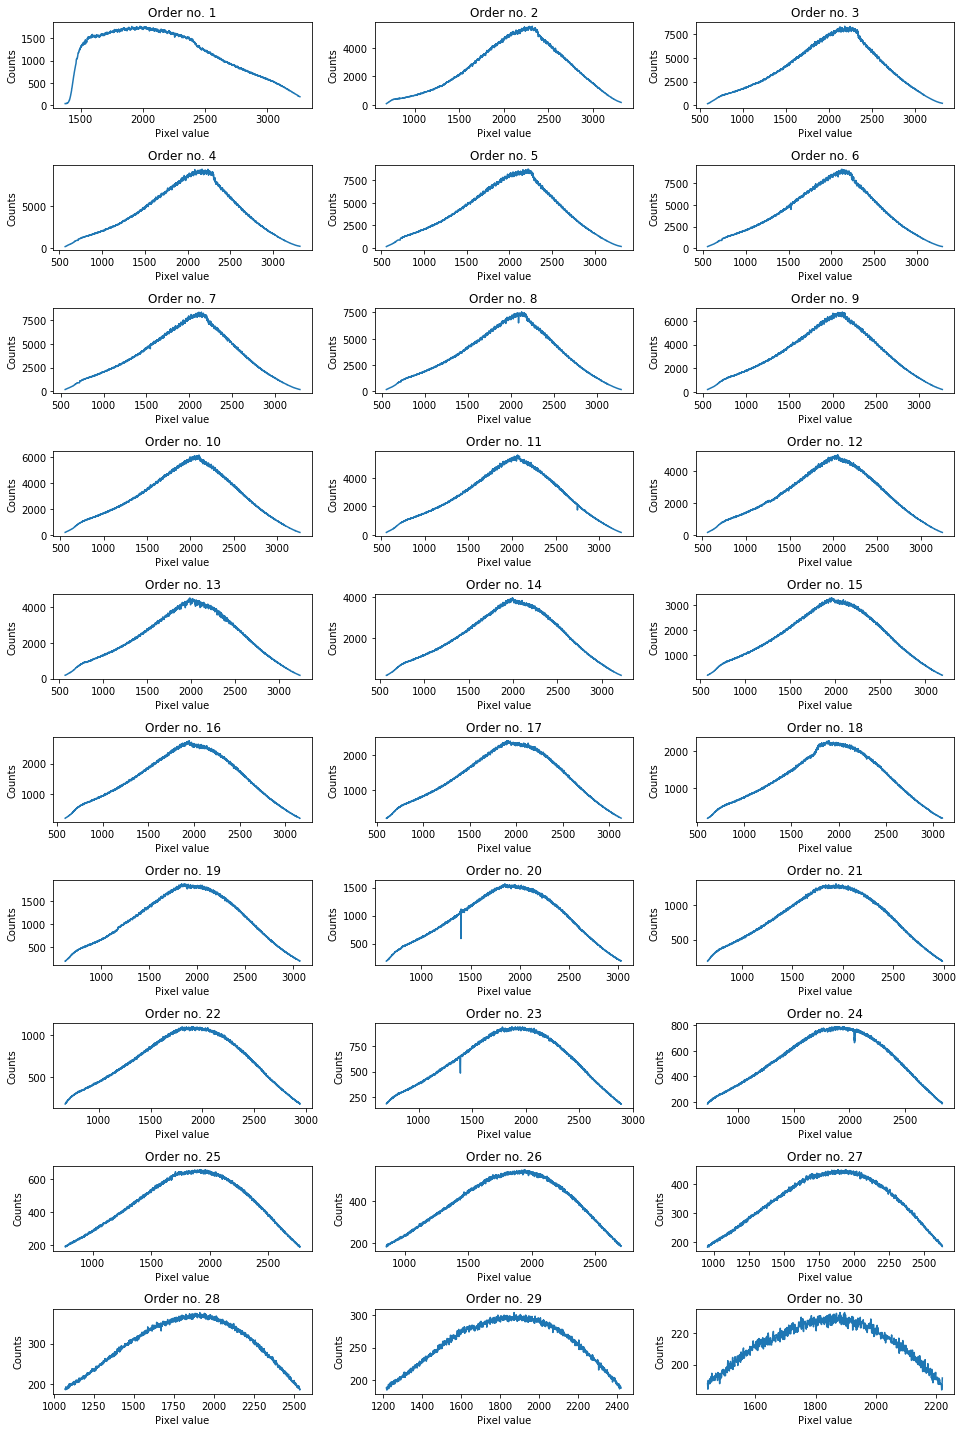

In [246]:
# Plot image
#plot_image(image_data, percentile_display=[10,98], name=fits_file.replace('.fits',''), spath=infolder, show=True) 

# Plot found orders overlay image
#plot_found_orders(new_orders, name=fits_file.replace('.fits',''), spath=infolder, show=True)

# Plot fitted orders
#plot_fitted_orders(image_data, polyfits, xlows, xhighs, percentile_display=[10,98], name=fits_file.replace('.fits',''), spath=infolder, show=True) 

# ---------------------------------------------------------------------
# saving polyinomal fits to file
#save_fits(polyfits, xlows, xhighs, fitmax=4, name=fits_file.replace('.fits',''), spath=infolder)

# ---------------------------------------------------------------------
# extraction code
#run_extraction(im, polyfits, xlows, xhighs, params['name'], params['ppath'], params['fpath'])
run_extraction(quartz_data, polyfits, xlows, xhighs, width=10, median=True, name=quartz_file.replace('.fits',''), spath=infolder)

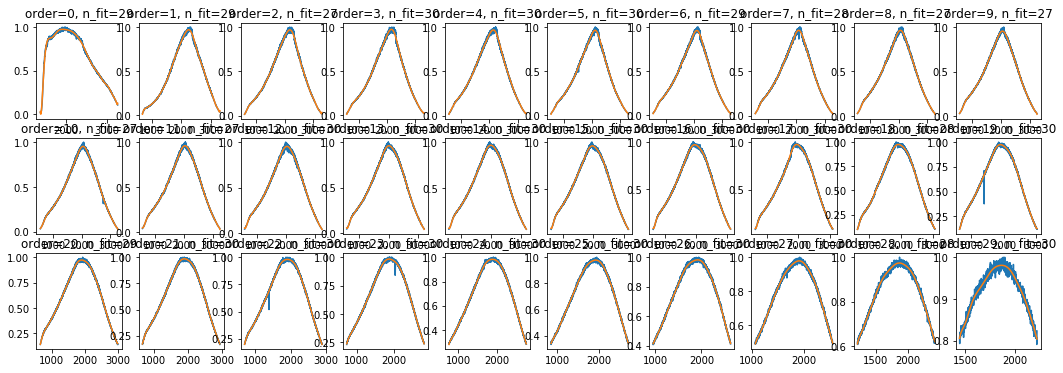

In [247]:
import warnings
warnings.simplefilter('ignore', np.RankWarning)

def fit_quartz(quartz_1d_extracted, nmin=1, nmax=30):

    with fits.open(quartz_1d_extracted) as hdul:
        quartz1d_data   = hdul[0].data
        hdul.close()

    #plt.imshow(quartz1d_data,vmin=0,vmax=10000,aspect=100,origin='bottom')
    #plt.xlabel('Spectral direction (pixels)')
    #plt.ylabel('Spectral order')
    #plt.title("Extracted Quartz lamp")
    #plt.colorbar()
    #plt.show()

    xarr=np.arange(quartz1d_data.shape[1])
    fit = quartz1d_data.copy()
    plt.figure(figsize=(18,6))
    for n in range(quartz1d_data.shape[0]):
        #if n == 0:
        yarr = quartz1d_data[n,:]
        yarr /= np.nanmax(yarr)
        idx_fit = np.isfinite(yarr)
        #ypfit, n_fit = eval_polynomialfit(xarr[idx_fit], yarr[idx_fit], nmin=1, nmax=30, chi2_threshold=150, debug=False)
        ypfit, n_fit = polynomialfit(xarr[idx_fit], yarr[idx_fit], nmin=nmin, nmax=nmax)
        yfit = np.polyval(ypfit,xarr)
        yfit[~idx_fit] = np.nan
        fit[n,:] = yfit
        plt.subplot(3,quartz1d_data.shape[0]/3,n+1)
        plt.plot(xarr,yarr)
        plt.plot(xarr,yfit)
        plt.title('order={}, n_fit={}'.format(n,n_fit))
    #plt.tight_layout()
    plt.show()
    
    return fit

quartz_1d_extracted = infolder + quartz_file.replace('.fits','') + '_spec.fits'
blaze_orders = fit_quartz(quartz_1d_extracted, nmin=1, nmax=30)


	 Extracting Orders...

	 Plotting Ordered Spectra...


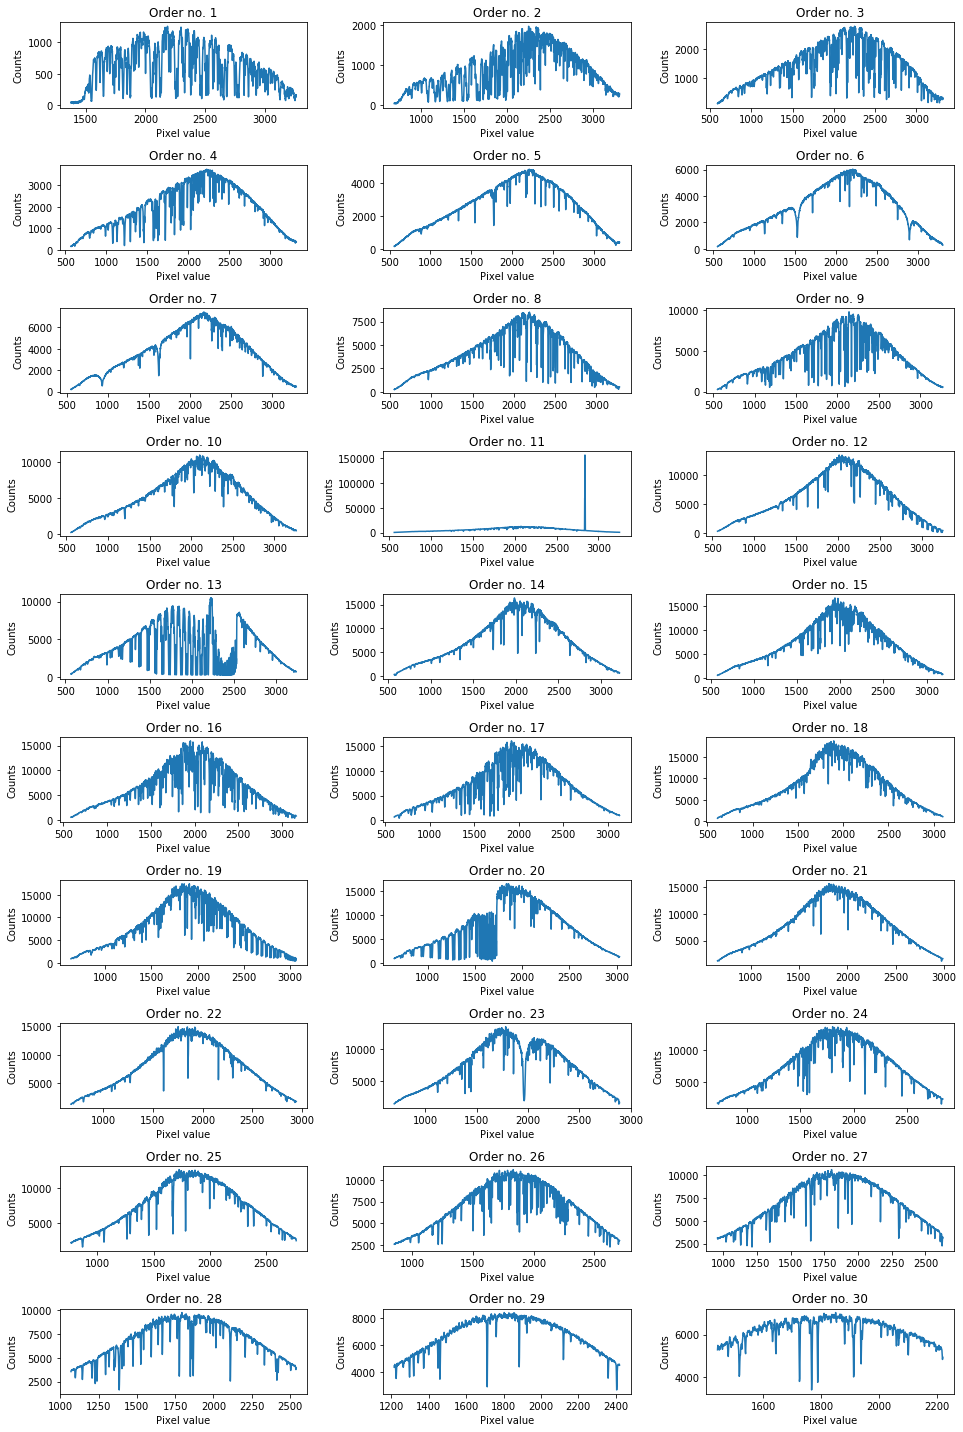


	 Extracting Orders...

	 Plotting Ordered Spectra...


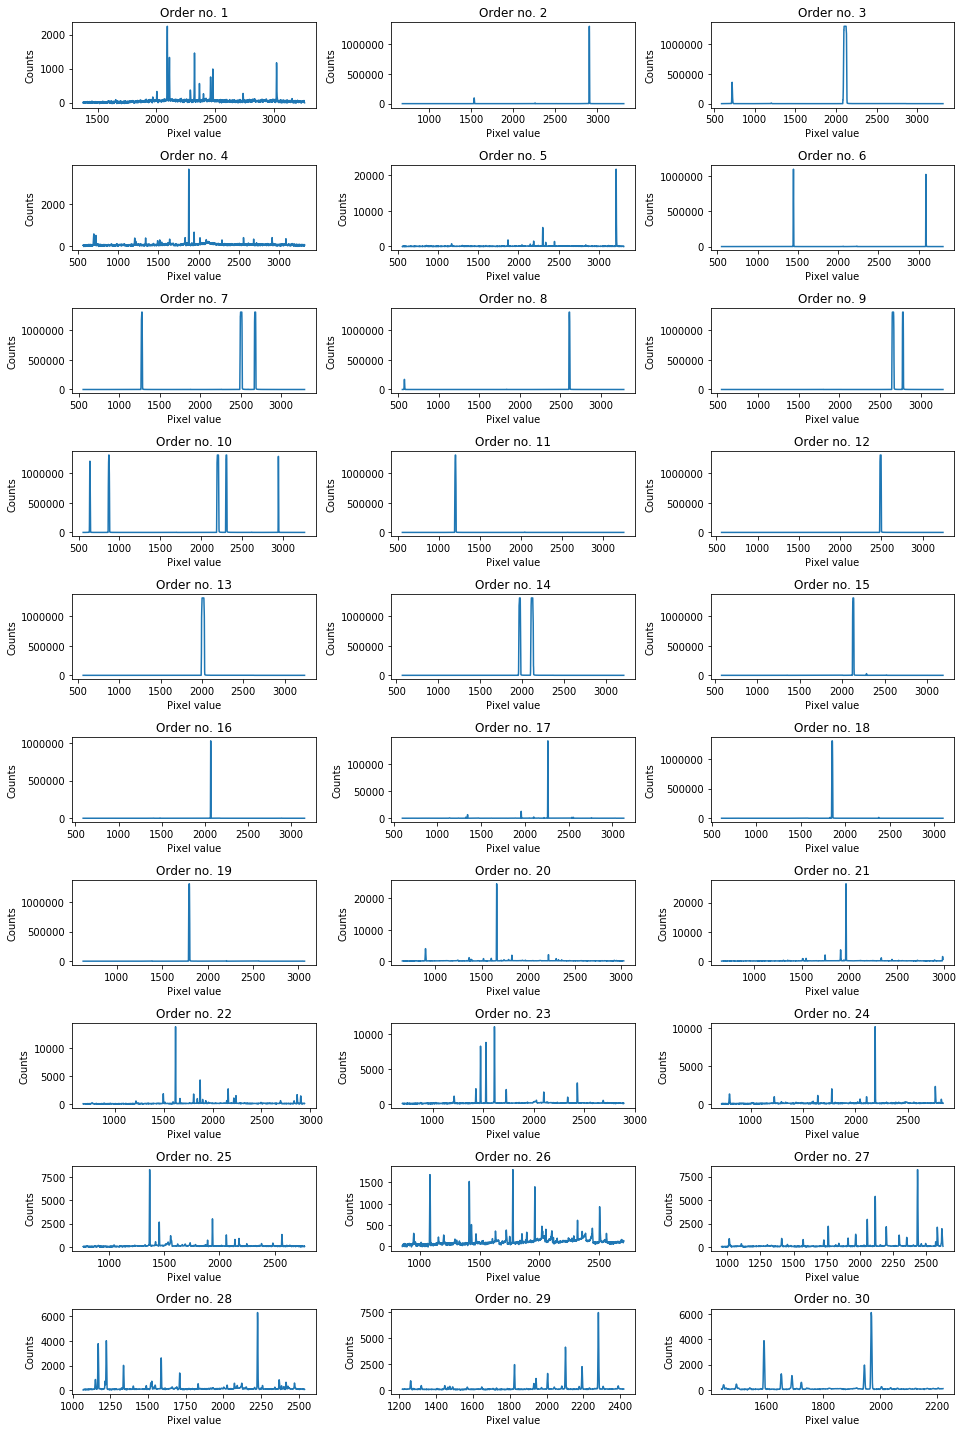

In [155]:

# extract
run_extraction(arc_data, polyfits, xlows, xhighs, width=10, name=arc_file.replace('.fits',''), spath=infolder)
run_extraction(sun_data, polyfits, xlows, xhighs, width=10, name=sun_file.replace('.fits',''), spath=infolder)

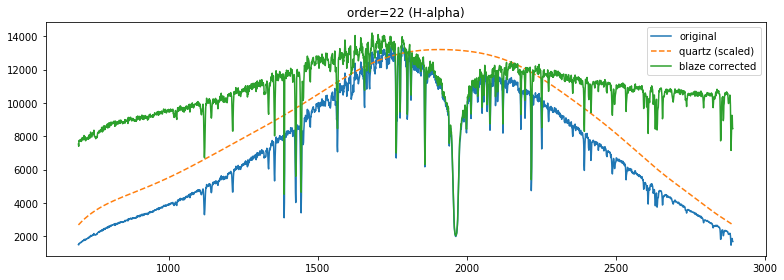

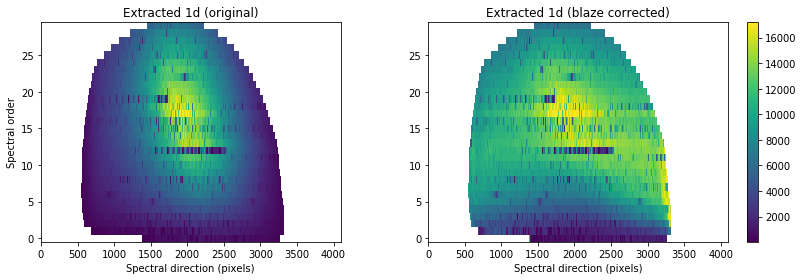

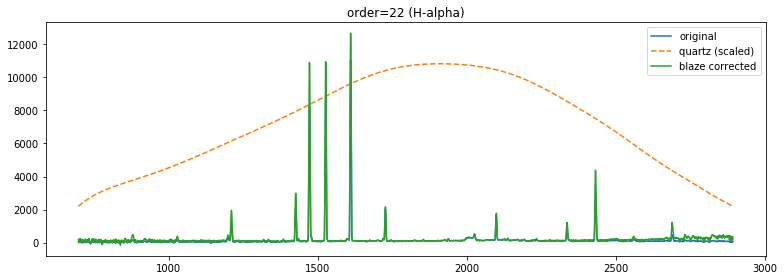

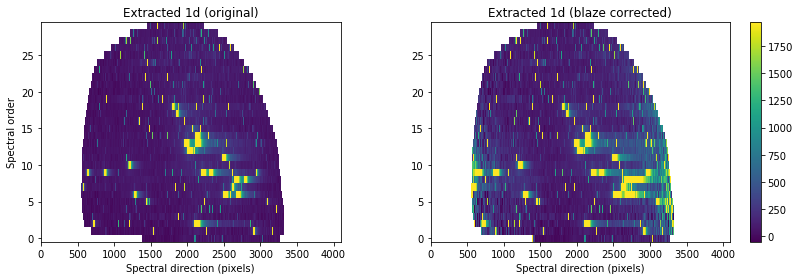

In [306]:
# apply blaze correction
#blaze_orders = fit_quartz(quartz_1d_extracted, nmin=1, nmax=30)
arc_1d_extracted = infolder + arc_file.replace('.fits','') + '_spec.fits'
sun_1d_extracted = infolder + sun_file.replace('.fits','') + '_spec.fits'


def apply_blaze(extracted1d, blaze_orders, displ_quantile=[2,98]):

    with fits.open(extracted1d) as hdul:
        data1d = hdul[0].data
        hdul.close()
    
    data1d_corr = data1d.copy()
    xarr=np.arange(data1d.shape[1])
    for n in range(data1d.shape[0]):
        yvals = data1d[n,:]
        blaze = blaze_orders[n,:]
        ycorr = yvals / blaze
        data1d_corr[n,:] = ycorr
        if n == 22:
            plt.figure(figsize=(11,4))
            plt.plot(xarr,yvals,label='original')
            plt.plot(xarr,blaze*np.nanmax(yvals),ls='--',label='quartz (scaled)')
            plt.plot(xarr,ycorr,label='blaze corrected')
            plt.legend()
            plt.title('order={} (H-alpha)'.format(n))
            plt.tight_layout()
            plt.show()
    #print(data1d.shape)
    #print(blaze_orders.shape)    
    
    
        
    displ_range = np.nanpercentile(data1d,displ_quantile)
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    plt.imshow(data1d,vmin=displ_range[0],vmax=displ_range[1],aspect=100,origin='bottom')
    plt.xlabel('Spectral direction (pixels)')
    plt.ylabel('Spectral order')
    plt.title("Extracted 1d (original)")
    
    plt.subplot(122)
    plt.imshow(data1d_corr,vmin=displ_range[0],vmax=displ_range[1],aspect=100,origin='bottom')
    plt.xlabel('Spectral direction (pixels)')
    plt.title("Extracted 1d (blaze corrected)")
    plt.colorbar()
    plt.tight_layout()
    plt.show()
    
apply_blaze(sun_1d_extracted, blaze_orders, displ_quantile=[0,99.9])
apply_blaze(arc_1d_extracted, blaze_orders, displ_quantile=[0,98])
    